In [1]:
import re
import math
from tqdm import tqdm
from pathlib import Path
from typing import List
from datasets import Dataset
from transformers import AutoTokenizer, EsmModel, EsmForMaskedLM
import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.SeqUtils import gc_fraction

In [71]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D")

inputs = tokenizer("AAVAV", return_tensors="pt")
outputs = model(**inputs, output_hidden_states=True)

last_hidden_states = outputs.hidden_states[-1]
last_hidden_states.shape

torch.Size([1, 7, 320])

In [51]:
codons = [
    "GGC", "GCC", "ATC","GAC","GAA","ATG","GTG","CTG","GTC","GCG","GAT","AAA",
    "GGT","AAG","GAG","ACC","AAC","GTT","ATT","GCA","CTC","CGC","GCT","CAG",
    "CCG","TTC","GTA","TCG","GGA","AAT","TAC","CTT","TTG","ACG","TCC","GGG",
    "AGC","CCC","ACA","ACT","TCT","TTA","CGT","TAT","CAA","CGG","TTT","CAC",
    "CCT","CCA","TGG","ATA","TCA","TGC","AGT","AGA", "CAT","TGT","CTA","AGG",
    "TAA","CGA","TGA","TAG",
]

print("Num codons", len(codons))

# get the current vocabulary
vocabulary = tokenizer.get_vocab().keys()

for codon in codons:
    # Check to see if codon is in the vocabulary or not (it won't be)
    # Keeping this line for generality
    if codon not in vocabulary:
        tokenizer.add_tokens(codon)

# add new embeddings to the embedding matrix of the transformer model
model.resize_token_embeddings(len(tokenizer))

Num codons 64


Embedding(97, 320)

In [52]:
model.resize_token_embeddings # before

<bound method PreTrainedModel.resize_token_embeddings of EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(97, 320)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): 

In [53]:
model.resize_token_embeddings # after -- see Embedding(97, 320)

<bound method PreTrainedModel.resize_token_embeddings of EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(97, 320)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): 

In [65]:
tokenizer.get_vocab()

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [54]:
tokenizer.get_added_vocab()

{'GGC': 33,
 'GCC': 34,
 'ATC': 35,
 'GAC': 36,
 'GAA': 37,
 'ATG': 38,
 'GTG': 39,
 'CTG': 40,
 'GTC': 41,
 'GCG': 42,
 'GAT': 43,
 'AAA': 44,
 'GGT': 45,
 'AAG': 46,
 'GAG': 47,
 'ACC': 48,
 'AAC': 49,
 'GTT': 50,
 'ATT': 51,
 'GCA': 52,
 'CTC': 53,
 'CGC': 54,
 'GCT': 55,
 'CAG': 56,
 'CCG': 57,
 'TTC': 58,
 'GTA': 59,
 'TCG': 60,
 'GGA': 61,
 'AAT': 62,
 'TAC': 63,
 'CTT': 64,
 'TTG': 65,
 'ACG': 66,
 'TCC': 67,
 'GGG': 68,
 'AGC': 69,
 'CCC': 70,
 'ACA': 71,
 'ACT': 72,
 'TCT': 73,
 'TTA': 74,
 'CGT': 75,
 'TAT': 76,
 'CAA': 77,
 'CGG': 78,
 'TTT': 79,
 'CAC': 80,
 'CCT': 81,
 'CCA': 82,
 'TGG': 83,
 'ATA': 84,
 'TCA': 85,
 'TGC': 86,
 'AGT': 87,
 'AGA': 88,
 'CAT': 89,
 'TGT': 90,
 'CTA': 91,
 'AGG': 92,
 'TAA': 93,
 'CGA': 94,
 'TGA': 95,
 'TAG': 96}

In [55]:
model.config

EsmConfig {
  "_name_or_path": "facebook/esm2_t6_8M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 320,
  "initializer_range": 0.02,
  "intermediate_size": 1280,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.31.0",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 97
}

In [2]:
def read_fasta_only_seq(fasta_file: Path) -> List[str]:
    """Reads fasta file sequences without description tag."""
    text = Path(fasta_file).read_text()
    pattern = re.compile("^>", re.MULTILINE)
    non_parsed_seqs = re.split(pattern, text)[1:]
    lines = [
        line.replace("\n", "") for seq in non_parsed_seqs for line in seq.split("\n", 1)
    ]
    return lines[1::2]

def group_and_contextualize(seq: str, k: int = 3): 
     return " ".join(seq[i : i + k] for i in range(0, len(seq), k)).upper()

In [ ]:
sequence_file = Path("/lambda_stor/homes/khippe/genslm_foundation/genome_data/mdh_sc23/fasta/mdh_natural_sequences.ffn")
sequences = read_fasta_only_seq(sequence_file)

codon_seqs = [group_and_contextualize(seq) for seq in sequences]
tokenized_codon_seqs = tokenizer(codon_seqs, return_tensors="pt", padding=True) # max_length=512, padding="max_length", truncation=True)


data = {
    "input_ids": tokenized_codon_seqs.input_ids.tolist(), 
    "attention_mask": tokenized_codon_seqs.attention_mask.tolist()
}

dataset = Dataset.from_dict(data)
dataset = dataset.train_test_split(test_size=0.05)
print(dataset)

In [64]:
tokenized_codon_seqs["input_ids"]

tensor([[ 0, 38, 69,  ...,  1,  1,  1],
        [ 0, 38, 52,  ...,  1,  1,  1],
        [ 0, 38, 44,  ...,  1,  1,  1],
        ...,
        [ 0, 38, 44,  ...,  1,  1,  1],
        [ 0, 38, 75,  ...,  1,  1,  1],
        [ 0, 39, 69,  ...,  1,  1,  1]])

In [28]:
# Does not include stop codons (61 total)
translation_table = {
        "TTT": "F", "TTC": "F", "TTA": "L", "TTG": "L",
        "TCT": "S", "TCC": "S", "TCA": "S", "TCG": "S",
        "TAT": "Y", "TAC": "Y",                           # noqa: E241
        "TGT": "C", "TGC": "C",             "TGG": "W",   # noqa: E241
        "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
        "CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P",
        "CAT": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
        "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R",
        "ATT": "I", "ATC": "I", "ATA": "I", "ATG": "M",
        "ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
        "AAT": "N", "AAC": "N", "AAA": "K", "AAG": "K",
        "AGT": "S", "AGC": "S", "AGA": "R", "AGG": "R",
        "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V",
        "GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A",
        "GAT": "D", "GAC": "D", "GAA": "E", "GAG": "E",
        "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    }

def codon_seq_to_amino_acid(codon_seq: str) -> str:
    # Skip stop codons
    return "".join(translation_table.get(codon, "") for codon in codon_seq)

In [29]:
amino_acid_seqs = [codon_seq_to_amino_acid(seq.split()) for seq in codon_seqs]

In [83]:
# Generate ESM AA embeddings for MDH sequences

# Batch size 1, slow :D
aa_embeddings = []
model.cuda()
with torch.no_grad():
    for seq in tqdm(amino_acid_seqs):
        inputs = tokenizer(seq, return_tensors="pt")
        inputs = {key: val.cuda() for key, val in inputs.items()}
        outputs = model(**inputs, output_hidden_states=True)
        last_hidden_states = outputs.hidden_states[-1]
        embeddings = last_hidden_states[0][1:-1, :].mean(dim=0).cpu().numpy() # Average over sequence length
        aa_embeddings.append(embeddings)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36631/36631 [04:02<00:00, 151.29it/s]


In [93]:
aa_embeddings = np.array(aa_embeddings)

In [25]:
def scatter_plot(plot_df, label_paint_name: str, label_note: str = ""):
    with plt.style.context("seaborn-poster"):
        fig = plt.figure(figsize=(10, 10))  # noqa
        ax = sns.scatterplot(
            data=plot_df,
            x="x",
            y="y",
            palette="viridis",
            hue=label_paint_name,
            legend=True,
            edgecolor="white",
            linewidth=0,
            s=15,
        )
        plt.xlabel(r"$z_1$", fontsize=22)
        plt.ylabel(r"$z_2$", fontsize=22)
        plt.suptitle(f"{label_paint_name} {label_note}")
        plt.rc("legend", fontsize=22)
        ax.tick_params(axis="both", which="major", labelsize=22)
        ax.tick_params(axis="both", which="minor", labelsize=22)
        sns.move_legend(
            ax,
            "lower center",
            bbox_to_anchor=(0.5, -0.25),
            ncol=4,
            title=None,
            frameon=False,
        )

In [96]:
tsne_embeddings = TSNE(n_components=2).fit_transform(aa_embeddings)

In [104]:
gc_content = [gc_fraction(seq) for seq in sequences]

array([[<Axes: title={'center': '0'}>]], dtype=object)

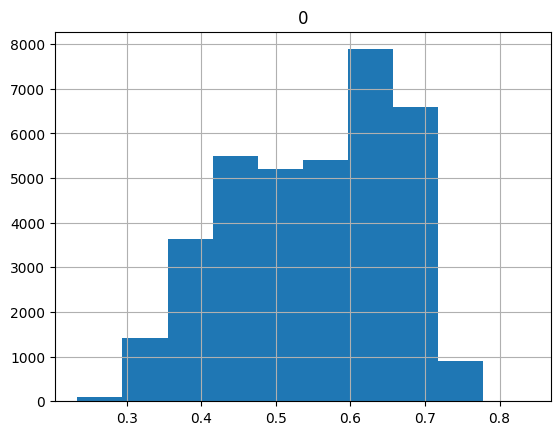

In [107]:
pd.DataFrame(gc_content).hist()

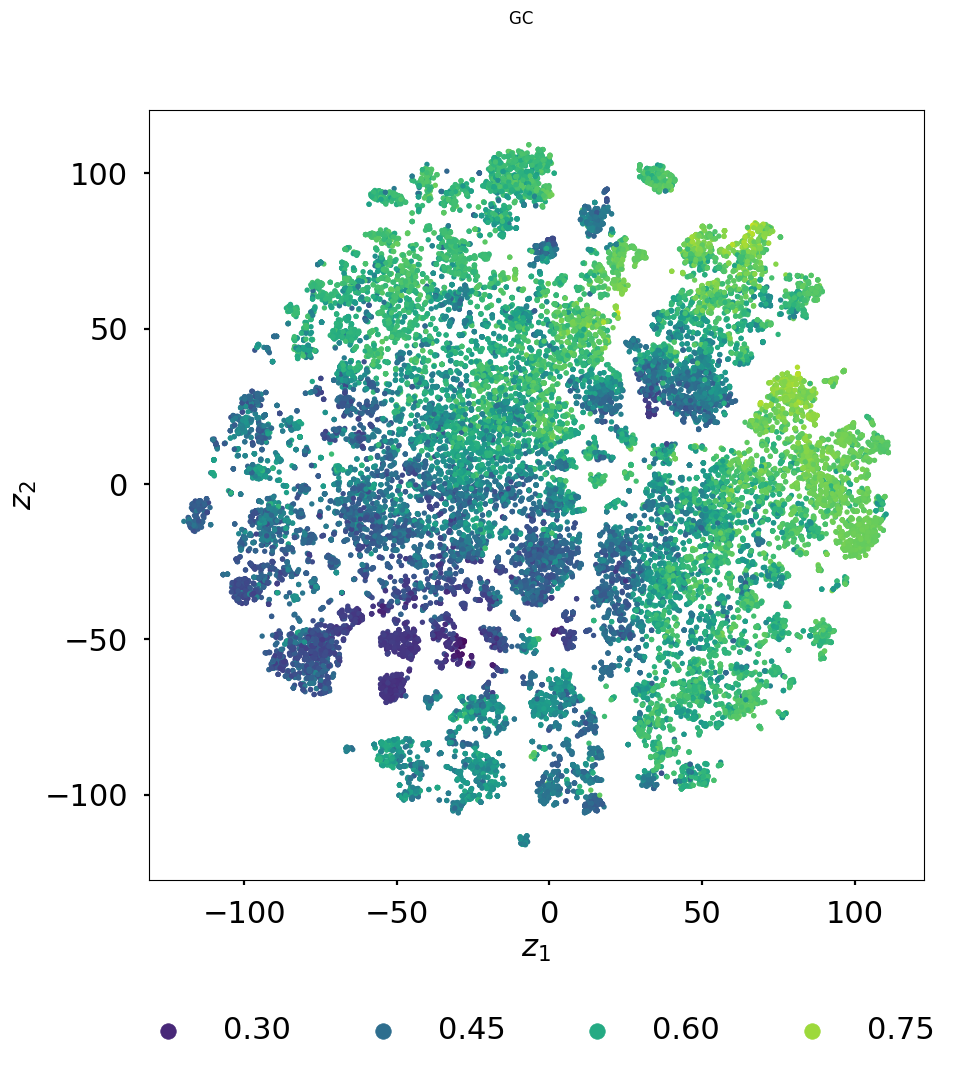

In [114]:
# ESM AA emebddings
plot_df = pd.DataFrame({"x": tsne_embeddings[:, 0], "y": tsne_embeddings[:, 1], "GC": gc_content})
scatter_plot(plot_df, "GC")

# Now lets try to train ESM on codons

In [3]:
# This code could be imported from ESM HF repo
def gelu(x):
    """
    This is the gelu implementation from the original ESM repo. Using F.gelu yields subtly wrong results.
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class EsmLMHead(nn.Module):
    """ESM Head for masked language modeling."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.decoder = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

    def forward(self, features, **kwargs):
        x = self.dense(features)
        x = gelu(x)
        x = self.layer_norm(x)

        # project back to size of vocabulary with bias
        x = self.decoder(x) + self.bias
        return x

In [4]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D")

In [5]:
codons = [
    "GGC", "GCC", "ATC","GAC","GAA","ATG","GTG","CTG","GTC","GCG","GAT","AAA",
    "GGT","AAG","GAG","ACC","AAC","GTT","ATT","GCA","CTC","CGC","GCT","CAG",
    "CCG","TTC","GTA","TCG","GGA","AAT","TAC","CTT","TTG","ACG","TCC","GGG",
    "AGC","CCC","ACA","ACT","TCT","TTA","CGT","TAT","CAA","CGG","TTT","CAC",
    "CCT","CCA","TGG","ATA","TCA","TGC","AGT","AGA", "CAT","TGT","CTA","AGG",
    "TAA","CGA","TGA","TAG",
]

print("Num codons", len(codons))

# get the current vocabulary
vocabulary = tokenizer.get_vocab().keys()

for codon in codons:
    # Check to see if codon is in the vocabulary or not (it won't be)
    # Keeping this line for generality
    if codon not in vocabulary:
        tokenizer.add_tokens(codon)

# add new embeddings to the embedding matrix of the transformer model
model.resize_token_embeddings(len(tokenizer))

Num codons 64


Embedding(97, 320)

In [6]:
model.lm_head.bias.shape # Still 33 vocab size!! That would cause a shape error

torch.Size([33])

In [7]:
# Make a new lm_head with uninitialized weights (we will be training this
lm_head_injection = EsmLMHead(model.config)
lm_head_injection

EsmLMHead(
  (dense): Linear(in_features=320, out_features=320, bias=True)
  (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  (decoder): Linear(in_features=320, out_features=97, bias=False)
)

In [8]:
# Inject lm_head into the ESM model
model.lm_head = lm_head_injection
model.lm_head.bias.shape # All fixed! Now we have the combined AA + Codon vocab

torch.Size([97])

In [9]:
model.resize_token_embeddings # after -- see Embedding(97, 320)

<bound method PreTrainedModel.resize_token_embeddings of EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(97, 320)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): 

In [10]:
sequence_file = Path("/lambda_stor/homes/khippe/genslm_foundation/genome_data/mdh_sc23/fasta/mdh_natural_sequences.ffn")
sequences = read_fasta_only_seq(sequence_file)

codon_seqs = [group_and_contextualize(seq) for seq in sequences]
tokenized_codon_seqs = tokenizer(codon_seqs, return_tensors="pt", padding=True) # max_length=512, padding="max_length", truncation=True)


data = {
    "input_ids": tokenized_codon_seqs.input_ids.tolist(), 
    "attention_mask": tokenized_codon_seqs.attention_mask.tolist()
}

dataset = Dataset.from_dict(data)
dataset = dataset.train_test_split(test_size=0.05)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 34799
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1832
    })
})


In [11]:
tokenized_codon_seqs

{'input_ids': tensor([[ 0, 38, 69,  ...,  1,  1,  1],
        [ 0, 38, 52,  ...,  1,  1,  1],
        [ 0, 38, 44,  ...,  1,  1,  1],
        ...,
        [ 0, 38, 44,  ...,  1,  1,  1],
        [ 0, 38, 75,  ...,  1,  1,  1],
        [ 0, 39, 69,  ...,  1,  1,  1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [150]:
# Batch size 1, slow :D
codon_embeddings = []
model.cuda()
with torch.no_grad():
    for seq in tqdm(codon_seqs):
        inputs = tokenizer(seq, return_tensors="pt")
        inputs = {key: val.cuda() for key, val in inputs.items()}
        outputs = model(**inputs, output_hidden_states=True)
        last_hidden_states = outputs.hidden_states[-1]
        embeddings = last_hidden_states[0][1:-1, :].mean(dim=0).cpu().numpy() # Average over sequence length
        codon_embeddings.append(embeddings)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36631/36631 [04:20<00:00, 140.38it/s]


In [152]:
codon_embeddings = np.array(codon_embeddings)
codon_embeddings.shape

(36631, 320)

In [153]:
tsne_embeddings = TSNE(n_components=2).fit_transform(codon_embeddings)

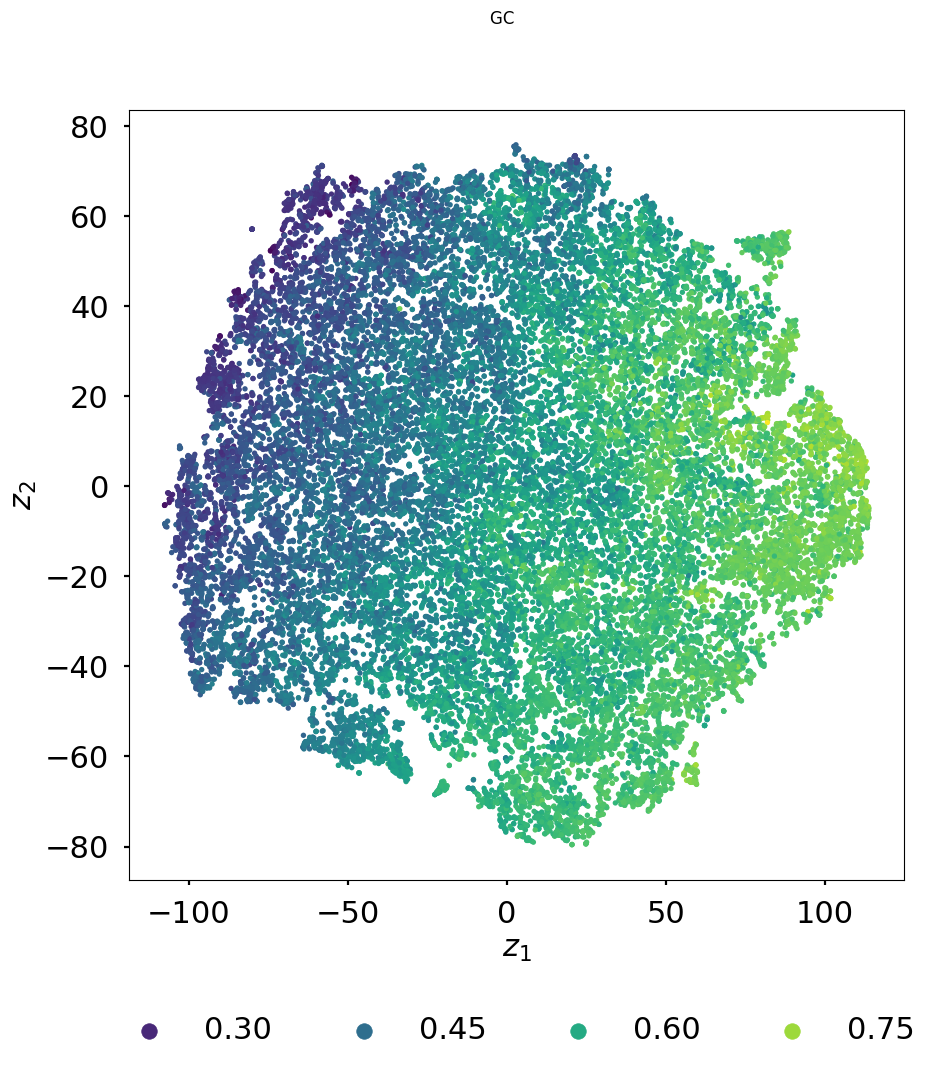

In [154]:
# ESM codon emebddings
plot_df = pd.DataFrame({"x": tsne_embeddings[:, 0], "y": tsne_embeddings[:, 1], "GC": gc_content})
scatter_plot(plot_df, "GC")

### The embeddings have structure, but they are not as segmented as the AA embeddings

# Lets fine-tune ESM on Codons

In [12]:
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

In [13]:
model_size = sum(t.numel() for t in model.parameters())
print(f"BERT size: {model_size/1000**2:.1f}M parameters")

BERT size: 7.9M parameters


In [18]:
args = TrainingArguments(
    output_dir="esm-codon-mdh-fine-tune",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    evaluation_strategy="steps",
    eval_steps=50,
    logging_steps=25,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=500,
    fp16=True,
    push_to_hub=False,
)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True)

# Build trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

# train
trainer.train()

Step,Training Loss,Validation Loss
50,3.782400,3.778079
100,3.727900,3.723716
150,3.675900,3.662575
200,3.609300,3.608796
250,3.511900,3.482389
300,3.347500,3.307584
350,3.060800,2.999019
400,2.779900,2.712949
450,2.526400,2.468427
500,2.325600,2.285019


TrainOutput(global_step=2720, training_loss=1.9262130127233617, metrics={'train_runtime': 2361.5874, 'train_samples_per_second': 147.354, 'train_steps_per_second': 1.152, 'total_flos': 5693713236257040.0, 'train_loss': 1.9262130127233617, 'epoch': 10.0})

# Now lets try inference again

In [19]:
# Batch size 1, slow :D
trained_codon_embeddings = []
model.cuda()
with torch.no_grad():
    for seq in tqdm(codon_seqs):
        inputs = tokenizer(seq, return_tensors="pt")
        inputs = {key: val.cuda() for key, val in inputs.items()}
        outputs = model(**inputs, output_hidden_states=True)
        last_hidden_states = outputs.hidden_states[-1]
        embeddings = last_hidden_states[0][1:-1, :].mean(dim=0).cpu().numpy() # Average over sequence length
        trained_codon_embeddings.append(embeddings)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36631/36631 [06:58<00:00, 87.59it/s]


NameError: name 'codon_embeddings' is not defined

In [20]:
trained_codon_embeddings = np.array(trained_codon_embeddings)
trained_codon_embeddings.shape

(36631, 320)

In [21]:
tsne_embeddings = TSNE(n_components=2).fit_transform(trained_codon_embeddings)

In [23]:
gc_content = [gc_fraction(seq) for seq in sequences]

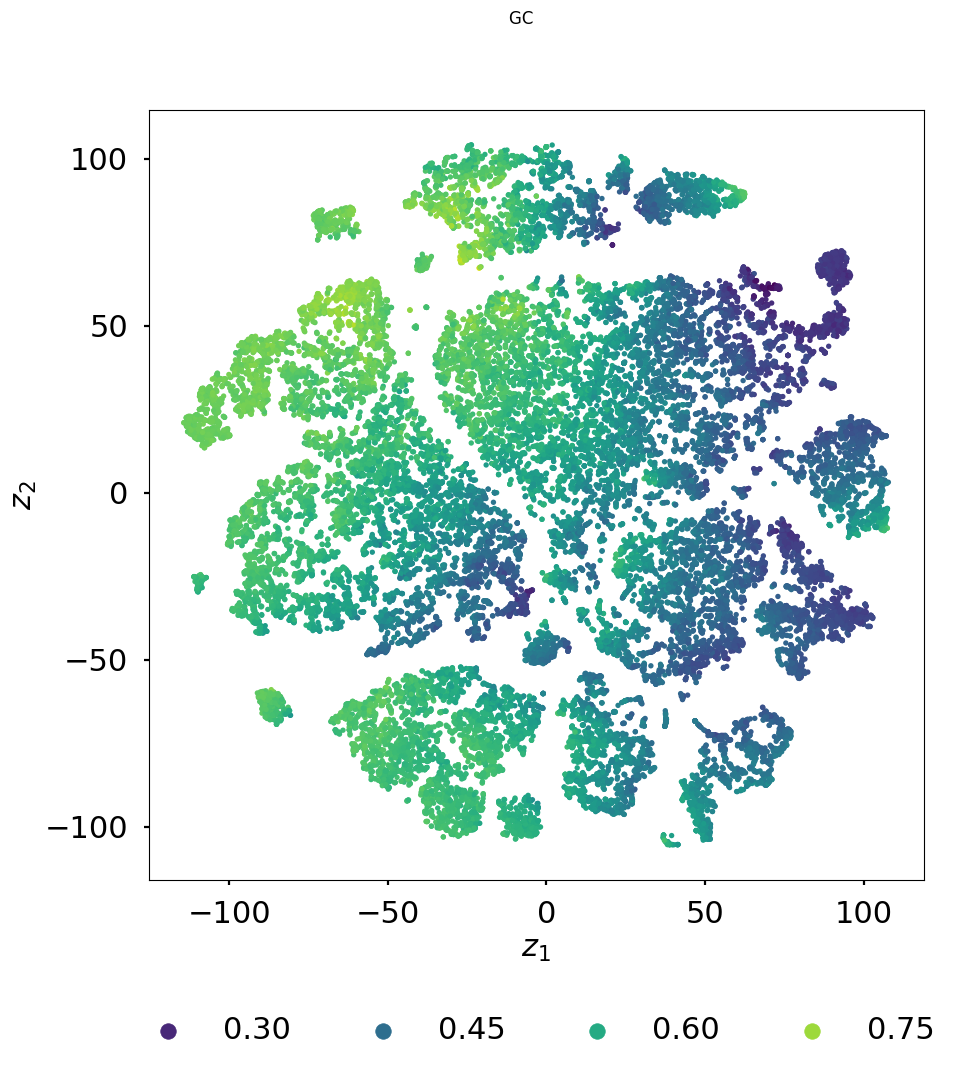

In [26]:
# ESM fine-tune on codons, codon emebddings
plot_df = pd.DataFrame({"x": tsne_embeddings[:, 0], "y": tsne_embeddings[:, 1], "GC": gc_content})
scatter_plot(plot_df, "GC")

# These ESM-codon embeddings look really nice!

# Lets try the amino acid embeddings again to see if the model forgot what it knew

In [30]:
amino_acid_seqs = [codon_seq_to_amino_acid(seq.split()) for seq in codon_seqs]

# Batch size 1, slow :D
new_aa_embeddings = []
model.cuda()
with torch.no_grad():
    for seq in tqdm(amino_acid_seqs):
        inputs = tokenizer(seq, return_tensors="pt")
        inputs = {key: val.cuda() for key, val in inputs.items()}
        outputs = model(**inputs, output_hidden_states=True)
        last_hidden_states = outputs.hidden_states[-1]
        embeddings = last_hidden_states[0][1:-1, :].mean(dim=0).cpu().numpy() # Average over sequence length
        new_aa_embeddings.append(embeddings)

new_aa_embeddings = np.array(new_aa_embeddings)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36631/36631 [05:25<00:00, 112.37it/s]


In [31]:
tsne_embeddings = TSNE(n_components=2).fit_transform(new_aa_embeddings)

<Figure size 640x480 with 0 Axes>

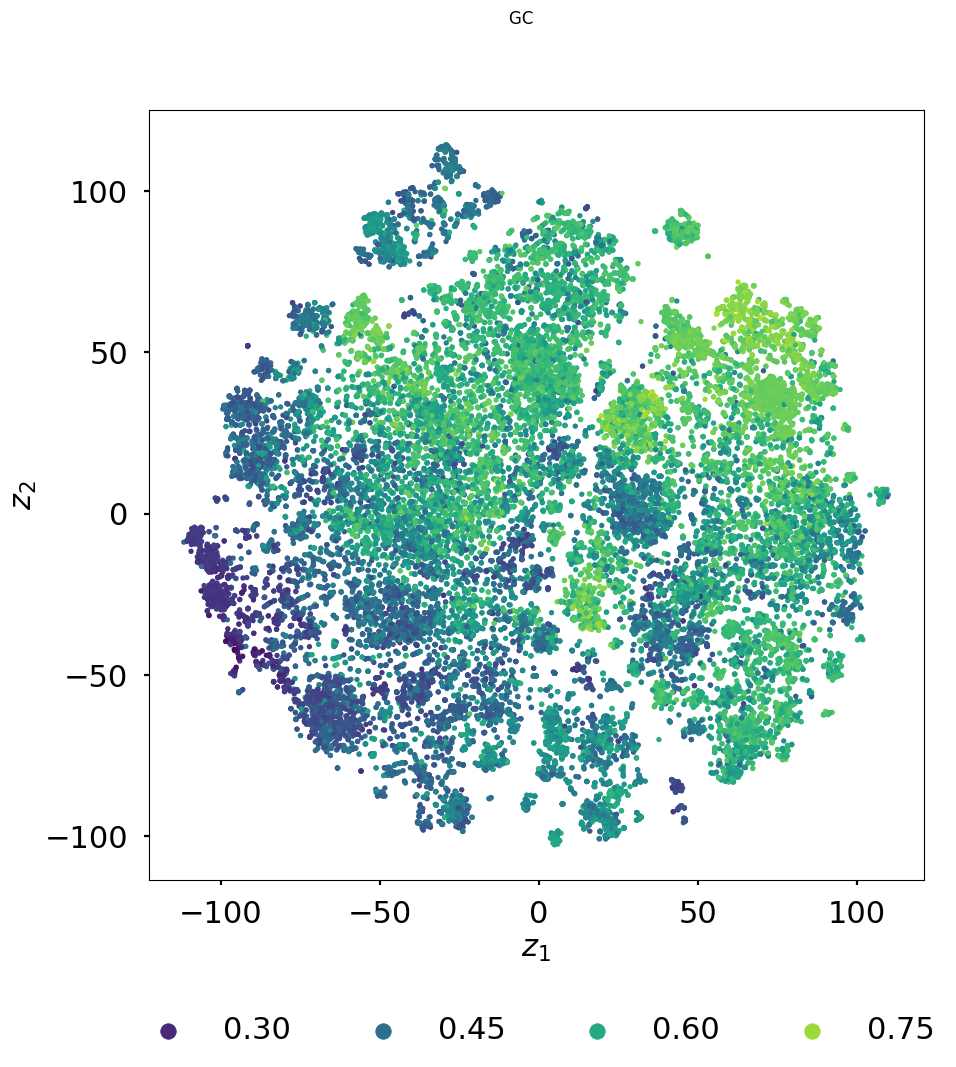

In [35]:
# ESM fine-tune on codons, AA emebddings
plot_df = pd.DataFrame({"x": tsne_embeddings[:, 0], "y": tsne_embeddings[:, 1], "GC": gc_content})
plt.clf()
scatter_plot(plot_df, "GC")
plt.show()

# AA Embeddings look similar. It might be good to continue training on a a mix of codon and AA